In [2]:
#MOTIF ANALYSIS USING INVIDIDUAL RT STOPS
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
from qcmodule import FrameKmer
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline

/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
plt.style.available

[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']

In [4]:
%%time

#The purpose of this is to perform motif analysis in each sample based on individual RT stops. I am going to do the simplest motif analysis with counting enriched kmers. Base this off of the Daminov et al., 2016 paper

#From the Damianov et al., 2016 paper
#The binding regions, defined as including 40 nucleotides upstream and 40 nucleotides downstream of each crosslinking site, were analyzed for enrichment of nucleotide pentamers. To control for nucleotide frequency biases, pentamer frequencies in the binding regions were compared to the distribution of pentamer frequencies in a large set of 81-nucleotide genomic intervals randomly chosen from the introns containing iCLIP clusters. GCAUG and UGCAU, the two pentamer derivatives of the UGCAUG motif, were the most enriched motifs in the binding regions (red dots, z-score > 645, Fig. S5). Several other near matches to the UGCAUG motif including CAUGU, GUAUG, UGUAU, GUGCA, CAUGC (orange dots, Fig. S5) were also highly enriched. Some of these partial matches were previously shown to bind Rbfox2 (Lambert et al., 2014).

#Generate the fasta files based on an extension interval

#File that contains the RT stops are labeled hnM_[DMSO/TAM]_RT_stops_sig. Import into pybedtools
dmso_rt_bt = pbt.BedTool('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig')
tam_rt_bt = pbt.BedTool('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig')

#slop in either direction and save
extension_interval = 15
dmso_rt_bt_extend = dmso_rt_bt.slop(b=extension_interval,genome='hg19')
dmso_rt_bt_extend.saveas('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension')
tam_rt_bt_extend = tam_rt_bt.slop(b=extension_interval,genome='hg19')
tam_rt_bt_extend.saveas('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_extension')

#generate fasta file
fasta = '/media/sam/Data1/annotations/hg19/hg19.fa'
dmso_rt_bt_extend_fasta = dmso_rt_bt_extend.sequence(fi=fasta,s=True)
dmso_rt_bt_extend_fasta.save_seqs('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension_fasta')
tam_rt_bt_extend_fasta = tam_rt_bt_extend.sequence(fi=fasta,s=True)
tam_rt_bt_extend_fasta.save_seqs('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_extension_fasta')

#Now we need suitable backgrounds. Use random intervals from the regions iCLIP clusters bind to. Since hnRNPM mostly binds to introns, use intersection intron
#NOTE - I AM NOT JUST USING THE INTRONIC RT STOPS BECAUSE IT SHOULD BE 95% OF THE TOTAL
#Consider just using the intronic RT stops
#Need to intersect with clusters with hg19_v19_introns from clipper regions
hg19_v19_introns_bt = pbt.BedTool('/home/sam/bin/clipper/clipper/data/regions/hg19_v19_introns.bed')
#Intersect with dmso
dmso_rt_bt_introns_intersect = hg19_v19_introns_bt.intersect(b=dmso_rt_bt,u=True,s=True)
dmso_rt_bt_introns_intersect.saveas('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect')
#Intersect with tam
tam_rt_bt_introns_intersect = hg19_v19_introns_bt.intersect(b=tam_rt_bt,u=True,s=True)
tam_rt_bt_introns_intersect.saveas('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect')

#Now that we have the introns, we need to select a large number of clusters of equal size to RT stop clusters.
#Use bedtools shuffle - but is it ok for me to use the same number of clusters but just shuffled. Or do I need more random samples?

#THIS CELL = 1 time shuffle - need to consider doing more than 1 shuffle

#DON'T USE PBT - IT FAILS FOR SOME REASON
!bedtools shuffle -i hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension -g /home/sam/bin/ucsc_tools/hg19.chrom.sizes -incl hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect > hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect_shuffle

!bedtools shuffle -i hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_extension -g /home/sam/bin/ucsc_tools/hg19.chrom.sizes -incl hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect > hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect_shuffle

#Get fasta
fasta = '/media/sam/Data1/annotations/hg19/hg19.fa'
dmso_rt_bt_introns_intersect_shuffle = pbt.BedTool('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect_shuffle')
dmso_rt_bt_introns_intersect_fasta = dmso_rt_bt_introns_intersect_shuffle.sequence(fi=fasta,s=True)
dmso_rt_bt_introns_intersect_fasta.save_seqs('hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect_shuffle_fasta')

tam_rt_bt_introns_intersect_shuffle = pbt.BedTool('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect_shuffle')
tam_rt_bt_introns_intersect_fasta = tam_rt_bt_introns_intersect_shuffle.sequence(fi=fasta,s=True)
tam_rt_bt_introns_intersect_fasta.save_seqs('hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect_shuffle_fasta')

CPU times: user 224 ms, sys: 3.58 s, total: 3.8 s
Wall time: 1min 4s


In [5]:
#Write a looper to generate n number of repeat shuffles of the things

CPU times: user 1min 13s, sys: 92 ms, total: 1min 13s
Wall time: 1min 13s


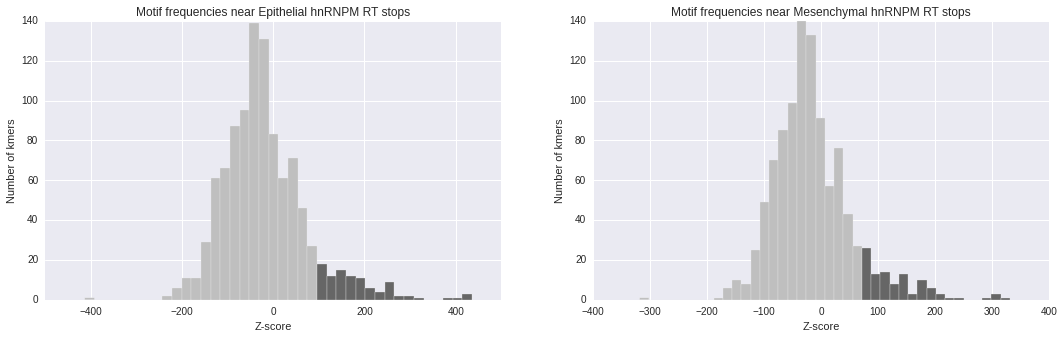

In [6]:
%%time

#Now calculate K-mer frequencies based on desired k-mer size and plot

#Choose K-mer size
kmer_size = 5

#Calculate Kmer frequencies
dmso_rt_freq = FrameKmer.kmer_freq_file(fastafile='hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_extension_fasta',word_size=kmer_size)
tam_rt_freq = FrameKmer.kmer_freq_file(fastafile='hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_extension_fasta',word_size=kmer_size)

#Now calculate the frequencies of each kmer so the total sums to 1
dmso_rt_freq_df = pd.DataFrame(dmso_rt_freq.items(),columns=['sequence','counts'])
dmso_sum = dmso_rt_freq_df.counts.astype('float').sum()
dmso_rt_freq_df['freq'] = dmso_rt_freq_df.apply(lambda row: float(row['counts'])/dmso_sum,axis=1)
dmso_rt_freq_df.sort_values('freq',ascending=False,inplace=True)

#Now calculate the frequencies of each kmer so the total sums to 1
tam_rt_freq_df = pd.DataFrame(tam_rt_freq.items(),columns=['sequence','counts'])
tam_sum = tam_rt_freq_df.counts.astype('float').sum()
tam_rt_freq_df['freq'] = tam_rt_freq_df.apply(lambda row: float(row['counts'])/tam_sum,axis=1)
tam_rt_freq_df.sort_values('freq',ascending=False,inplace=True)


#Calculate kmer frequencies of the introns
dmso_rt_intron_freq = FrameKmer.kmer_freq_file(fastafile='hnM_DMSO_clipper/hnM_DMSO_RT_stops_clipper_sig_introns_intersect_shuffle_fasta',word_size=kmer_size)

tam_rt_intron_freq = FrameKmer.kmer_freq_file(fastafile='hnM_TAM_clipper/hnM_TAM_RT_stops_clipper_sig_introns_intersect_shuffle_fasta',word_size=kmer_size)

#For the introns
#Now calculate the frequencies of each kmer so the total sums to 1
dmso_rt_intron_freq_df = pd.DataFrame(dmso_rt_intron_freq.items(),columns=['sequence','counts'])
dmso_intron_sum = dmso_rt_intron_freq_df.counts.astype('float').sum()
dmso_rt_intron_freq_df['freq'] = dmso_rt_intron_freq_df.apply(lambda row: float(row['counts'])/dmso_intron_sum,axis=1)
dmso_rt_intron_freq_df.sort_values('freq',ascending=False,inplace=True)

#Now calculate the frequencies of each kmer so the total sums to 1
tam_rt_intron_freq_df = pd.DataFrame(tam_rt_intron_freq.items(),columns=['sequence','counts'])
tam_intron_sum = tam_rt_intron_freq_df.counts.astype('float').sum()
tam_rt_intron_freq_df['freq'] = tam_rt_intron_freq_df.apply(lambda row: float(row['counts'])/tam_intron_sum,axis=1)
tam_rt_intron_freq_df.sort_values('freq',ascending=False,inplace=True)

#Now that I have all of the frequencies for the kmers, I need to calculate the z-score for each kmers
#The TWO PROPORTION Z TEST http://www.statisticshowto.com/z-test/
#Z = (freq1 - freq2) - 0 / sqrt(p(1-p)(1/counts1+1/counts2))
#p = (counts1+counts2)/(sum1+sum2)

#save each of the frequency files as CSVs
dmso_rt_freq_df.to_csv('motif_analysis/hnM_DMSO_RT_kmer_frequencies',sep='\t',index=False)
dmso_rt_intron_freq_df.to_csv('motif_analysis/hnM_DMSO_RT_intron_shuffle_kmer_frequencies',sep='\t',index=False)
tam_rt_freq_df.to_csv('motif_analysis/hnM_TAM_RT_kmer_frequencies',sep='\t',index=False)
tam_rt_intron_freq_df.to_csv('motif_analysis/hnM_TAM_RT_intron_shuffle_kmer_frequencies',sep='\t',index=False)

#Read them back in as dataframes
dmso_rt_freq_df = pd.read_csv('motif_analysis/hnM_DMSO_RT_kmer_frequencies',sep='\t')
dmso_rt_intron_freq_df = pd.read_csv('motif_analysis/hnM_DMSO_RT_intron_shuffle_kmer_frequencies',sep='\t')
tam_rt_freq_df = pd.read_csv('motif_analysis/hnM_TAM_RT_kmer_frequencies',sep='\t')
tam_rt_intron_freq_df = pd.read_csv('motif_analysis/hnM_TAM_RT_intron_shuffle_kmer_frequencies',sep='\t')

#Merge the dataframes with clipper on the left, introns on the right
#X = RT stops
#Y = Random intervals

dmso_rt_combined_freq = pd.merge(dmso_rt_freq_df,dmso_rt_intron_freq_df,on='sequence')
tam_rt_combined_freq = pd.merge(tam_rt_freq_df,tam_rt_intron_freq_df,on='sequence')

#Now calculate the sum of frequencies of sample and control
#Also calculate the sum of all the kmer
def freq_x_plus_y(row):
    freq_sum = row['freq_x']+row['freq_y']
    return freq_sum
dmso_x_sum = dmso_rt_combined_freq.counts_x.astype('float').sum()
dmso_y_sum = dmso_rt_combined_freq.counts_y.astype('float').sum()

tam_x_sum = tam_rt_combined_freq.counts_x.astype('float').sum()
tam_y_sum = tam_rt_combined_freq.counts_y.astype('float').sum()

#Now write a function to calculate the Z score for each things
def frequency_z_score_dmso(row):
    p = (float(row['counts_x']+row['counts_y'])) / (dmso_x_sum + dmso_y_sum)
    z = (row['freq_x'] - row['freq_y']) / np.sqrt((p*(1-p)*((1/dmso_x_sum)+(1/dmso_y_sum))))
    return z
    
def frequency_z_score_tam(row):
    p = (float(row['counts_x']+row['counts_y'])) / (tam_x_sum + tam_y_sum)
    z = (row['freq_x'] - row['freq_y']) / np.sqrt((p*(1-p)*((1/tam_x_sum)+(1/tam_y_sum))))
    return z

#calculate the z scores
dmso_rt_combined_freq['z_score'] = dmso_rt_combined_freq.apply(frequency_z_score_dmso,axis=1)
tam_rt_combined_freq['z_score'] = tam_rt_combined_freq.apply(frequency_z_score_tam,axis=1)

#Sort the dataframes
dmso_rt_combined_freq.sort_values('z_score',ascending=False,inplace=True)
tam_rt_combined_freq.sort_values('z_score',ascending=False,inplace=True)

#Save the tables of kmer with associated Z score
dmso_rt_combined_freq.sort_values('z_score',ascending=False).to_csv('motif_analysis/hnM_DMSO_kmer_z_score',sep='\t',index=False)
tam_rt_combined_freq.sort_values('z_score',ascending=False).to_csv('motif_analysis/hnM_TAM_kmer_z_score',sep='\t',index=False)

#Now plot a histogram highlighting the Z-scores in bins
#Consider shading top 10% of z scores
freq_hist, (dmso,tam) = plt.subplots(1,2,figsize=(18,5))
#This allows you to collect information about the histogram
counts, bins, patches = dmso.hist(dmso_rt_combined_freq.z_score,bins=40,color='0.75')
dmso.set_title('Motif frequencies near Epithelial hnRNPM RT stops')
dmso.set_xlabel('Z-score')
dmso.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(dmso_rt_combined_freq.z_score,90)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')


counts, bins, patches = tam.hist(tam_rt_combined_freq.z_score,bins=40,color='0.75')
tam.set_title('Motif frequencies near Mesenchymal hnRNPM RT stops')
tam.set_xlabel('Z-score')
tam.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(tam_rt_combined_freq.z_score,90)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')

freq_hist.savefig('motif_analysis/epi_and_mes_kmer_z-score_histograms',format='png',dpi=300)

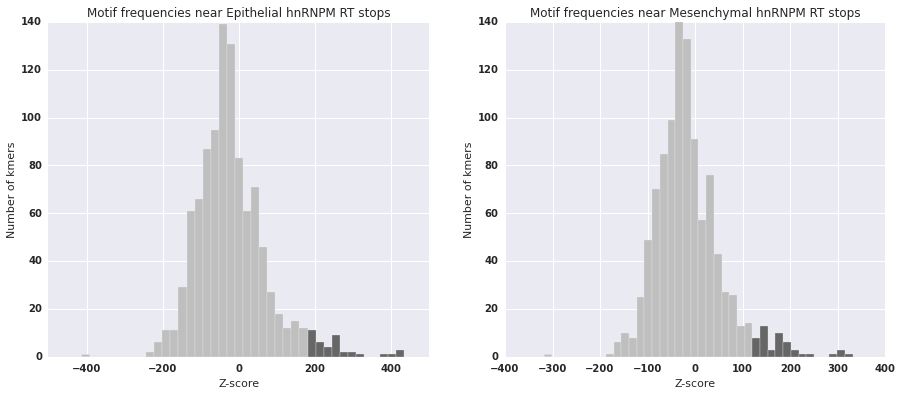

In [105]:
#Now plot a histogram highlighting the Z-scores in bins

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25}

plt.rc('font', **font)

freq_hist, (dmso,tam) = plt.subplots(1,2,figsize=(15,6))

#This allows you to collect information about the histogram
counts, bins, patches = dmso.hist(dmso_rt_combined_freq.z_score,bins=40,color='0.75')
dmso.set_title('Motif frequencies near Epithelial hnRNPM RT stops')
dmso.set_xlabel('Z-score')
dmso.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(dmso_rt_combined_freq.z_score,95)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')


counts, bins, patches = tam.hist(tam_rt_combined_freq.z_score,bins=40,color='0.75')
tam.set_title('Motif frequencies near Mesenchymal hnRNPM RT stops')
tam.set_xlabel('Z-score')
tam.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(tam_rt_combined_freq.z_score,95)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')

freq_hist.savefig('motif_analysis/epi_and_mes_kmer_z-score_histograms',format='png',dpi=300)

In [93]:
#Collect a list of all of the GU rich pentamers specified in the Black paper
#Rules - G and T only. No more than 2 Gs or 2 Us next to each other. No more than 3 Us or Gs total
#These are from the Damianov et al., 2016 paper

hnM_pentamers = ['TGTGT','GTGTG','TTGTG','GTGTT','TGTTG','TGTGG','GTTGT','GGTGT','TGGTT','TTGGT','TGGTG','GTGGT','GTTGG','GGTTG']

Rbfox_pentamers = ['GCATG','TGCAT','CATGU','GTATG','TGTAT','GTGCA','CATGC']

hnRNP_C_pentamers = ['TTTTG','GTTTT','TTTTT','ATTTT','TTTTA','TTTTC','CTTTT']

hnRNP_H_pentamers = ['GGGGT','CGGGG','GGGGG','TGGGG','GGGGC','GGGGA','AGGGG']

#How can you select colums that pertain to something in a series... sue isin!
#Make sure to set a y value using the following key:
#hnM = 1
#Rbfox = 2
#hnRNP_C = 3
#hnRNP_H = 4

dmso_hnM = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(hnM_pentamers)]
dmso_hnM['RBP'] = 1
dmso_hnM['RBP_name'] = 'hnRNPM'

dmso_Rbfox = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(Rbfox_pentamers)]
dmso_Rbfox['RBP'] = 2
dmso_Rbfox['RBP_name'] = 'Rbfox'

dmso_hnC = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(hnRNP_C_pentamers)]
dmso_hnC['RBP'] = 3
dmso_hnC['RBP_name'] = 'hnRNPC'

dmso_hnH = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(hnRNP_H_pentamers)]
dmso_hnH['RBP'] = 4
dmso_hnH['RBP_name'] = 'hnRNPH'

tam_hnM = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(hnM_pentamers)]
tam_hnM['RBP'] = 1
tam_hnM['RBP_name'] = 'hnRNPM'

tam_Rbfox = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(Rbfox_pentamers)]
tam_Rbfox['RBP'] = 2
tam_Rbfox['RBP_name'] = 'Rbfox'

tam_hnC = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(hnRNP_C_pentamers)]
tam_hnC['RBP'] = 3
tam_hnC['RBP_name'] = 'hnRNPC'

tam_hnH = tam_rt_combined_freq.loc[tam_rt_combined_freq['sequence'].isin(hnRNP_H_pentamers)]
tam_hnH['RBP'] = 4
tam_hnH['RBP_name'] = 'hnRNPH'

#concat together

dmso_concat = pd.concat([dmso_hnM,dmso_Rbfox,dmso_hnC,dmso_hnH],ignore_index=True)
tam_concat = pd.concat([tam_hnM,tam_Rbfox,tam_hnC,tam_hnH],ignore_index=True)

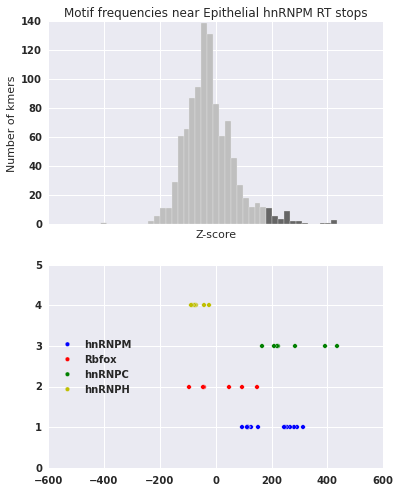

In [111]:
#DMSO
#How can I plot colorful dots corresponding to specific kmers under the plot
#How to get this to work --> very difficult to use a line

#Now plot a histogram highlighting the Z-scores in bins
#Consider shading top 10% of z scores
freq_hist, (dmso,dmso_line) = plt.subplots(2,1,figsize=(6,8),sharex=True,facecolor='white')
#This allows you to collect information about the histogram
counts, bins, patches = dmso.hist(dmso_rt_combined_freq.z_score,bins=40,color='0.75')
dmso.set_title('Motif frequencies near Epithelial hnRNPM RT stops')
dmso.set_xlabel('Z-score')
dmso.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(dmso_rt_combined_freq.z_score,95)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')

#This does not work well - I can't get any of the features to plot        
dmso_line.scatter(dmso_hnM.z_score, dmso_hnM.RBP,marker='o',c='b',label = 'hnRNPM')
dmso_line.scatter(dmso_Rbfox.z_score, dmso_Rbfox.RBP,marker='o',c='r',label = 'Rbfox')
dmso_line.scatter(dmso_hnC.z_score, dmso_hnC.RBP,marker='o',c='g',label = 'hnRNPC')
dmso_line.scatter(dmso_hnH.z_score, dmso_hnH.RBP,marker='o',c='y',label = 'hnRNPH')

dmso_line.set_xlabel = 'Z-score'
dmso_line.set_ybound(lower=0,upper=5)
dmso_line.legend(loc='center left')

freq_hist.savefig('motif_analysis/epi_and_damianov_motifs',format='png',dpi=300)

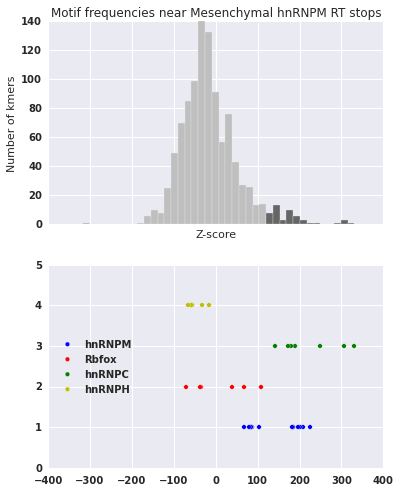

In [110]:
#TAM
#How can I plot colorful dots corresponding to specific kmers under the plot
#How to get this to work --> very difficult to use a line

#Now plot a histogram highlighting the Z-scores in bins
#Consider shading top 10% of z scores
freq_hist, (tam,tam_line) = plt.subplots(2,1,figsize=(6,8),sharex=True,facecolor='white')
#This allows you to collect information about the histogram
counts, bins, patches = tam.hist(tam_rt_combined_freq.z_score,bins=40,color='0.75')
tam.set_title('Motif frequencies near Mesenchymal hnRNPM RT stops')
tam.set_xlabel('Z-score')
tam.set_ylabel('Number of kmers')
# Change the colors of bars at the edges...
ninetieth = np.percentile(tam_rt_combined_freq.z_score,95)
for patch, sigside in zip(patches, bins):
    if sigside > ninetieth:
        patch.set_facecolor('0.4')

#This does not work well - I can't get any of the features to plot        
tam_line.scatter(tam_hnM.z_score, tam_hnM.RBP,marker='o',c='b',label = 'hnRNPM')
tam_line.scatter(tam_Rbfox.z_score, tam_Rbfox.RBP,marker='o',c='r',label = 'Rbfox')
tam_line.scatter(tam_hnC.z_score, tam_hnC.RBP,marker='o',c='g',label = 'hnRNPC')
tam_line.scatter(tam_hnH.z_score, tam_hnH.RBP,marker='o',c='y',label = 'hnRNPH')

tam_line.set_xlabel = 'Z-score'
tam_line.set_ybound(lower=0,upper=5)
tam_line.legend(loc='center left')

freq_hist.savefig('motif_analysis/mes_and_damianov_motifs',format='png',dpi=300)

In [33]:
#Collect a list of all of the GU rich pentamers specified in the Black paper
#Rules - G and T only. No more than 2 Gs or 2 Us next to each other. No more than 3 Us or Gs total
#These are from the black paper
hnM_pentamers = ['TGTGT','GTGTG','TTGTG','GTGTT','TGTTG','TGTGG','GTTGT','GGTGT','TGGTT','TTGGT','TGGTG','GTGGT','GTTGG','GGTTG']
hnM_pentamers_df = pd.Series(hnM_pentamers,name='sequence')

#How can you select colums that pertain to something in a series... sue isin!
dmso_rt_combined_freq_black_pentamers = dmso_rt_combined_freq.loc[dmso_rt_combined_freq['sequence'].isin(hnM_pentamers_df)]


In [117]:
tam_hnM[['sequence','z_score']]

,sequence,z_score
16,TGTTG,225.038934
20,TTGTG,209.186518
34,GTTGT,202.194584
26,TTGGT,197.288234
29,TGGTT,184.468945
17,TGTGT,184.267573
35,GTGTT,180.986847
64,TGTGG,103.857527
137,GTTGG,85.976010
67,GTGTG,83.486548


In [118]:
tam_Rbfox[['sequence','z_score']]

,sequence,z_score
47,TGTAT,108.351686
210,GTATG,67.594494
186,TGCAT,37.905444
490,GTGCA,-36.156674
494,GCATG,-37.314122
645,CATGC,-71.059579


In [119]:
tam_hnC[['sequence','z_score']]

,sequence,z_score
1,TTTTG,330.960084
4,GTTTT,305.377869
0,TTTTT,248.842643
8,TTTTC,188.067062
11,CTTTT,179.827714
6,ATTTT,173.249991
9,TTTTA,141.612686


In [120]:
tam_hnH[['sequence','z_score']]

,sequence,z_score
507,GGGGT,-15.582416
365,TGGGG,-32.737321
634,AGGGG,-56.188611
922,CGGGG,-56.634206
590,GGGGA,-56.766025
724,GGGGG,-59.606434
743,GGGGC,-65.738079


In [24]:
hnM_pentamers_df

0     TGTGT
1     GTGTG
2     TTGTG
3     GTGTT
4     TGTTG
5     TGTGG
6     GTTGT
7     GGTGT
8     TGGTT
9     TTGGT
10    TGGTG
11    GTGGT
12    GTTGG
13    GGTTG
Name: sequence, dtype: object

In [17]:
ar = dmso_rt_combined_freq.z_score
dmso_rt_combined_freq

,sequence,counts_x,freq_x,counts_y,freq_y,z_score
1,TTTTG,406827,0.011111,98434,0.002689,435.303232
4,TTGTT,336947,0.009203,70428,0.001924,418.685631
2,TTTGT,363970,0.009941,86112,0.002352,415.392162
3,TGTTT,346532,0.009465,86661,0.002367,395.955380
5,GTTTT,328473,0.008971,79309,0.002166,391.224190
13,TGTTG,211822,0.005785,51099,0.001396,313.970086
19,TTGTG,184259,0.005033,44765,0.001223,291.901840
14,TTTGG,209998,0.005735,59765,0.001633,289.742166
0,TTTTT,523077,0.014286,271235,0.007409,284.046068
30,GTTGT,150215,0.004103,31214,0.000853,279.693059


In [436]:
dmso_rt_combined_freq.tail()

,sequence,counts_x,freq_x,counts_y,freq_y,z_score
767,ACACA,8716,0.000238,65974,0.001802,-209.642663
619,AAACA,16668,0.000455,85549,0.002337,-215.626257
681,ACAAA,13345,0.000364,85149,0.002326,-228.977015
609,CAAAA,17187,0.000469,98512,0.002691,-239.309854
295,AAAAA,41316,0.001128,272547,0.007445,-413.679563


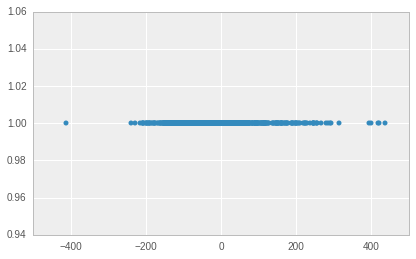

In [437]:
ar = dmso_rt_combined_freq.z_score
set_value = 1
a = plt.plot(ar, len(ar) * [set_value], "x",marker='o',markersize=5)

In [438]:
a

In [439]:
test = dmso_rt_combined_freq[['sequence','z_score']].sort_values('z_score',ascending=False).head()
test

,sequence,z_score
1,TTTTG,435.190011
4,TTGTT,420.039070
2,TTTGT,416.559442
3,TGTTT,398.011783
5,GTTTT,392.649248


In [440]:
#plot the genes as well
# fig = plt.figure(figsize=(8,8),edgecolor='black')
# ax = plt.gca()
# plt.scatter(subset_tam.hnM_DMSO_clip_gene_fpkm_norm_1,subset_tam.hnM_TAM_clip_gene_fpkm_norm_1,label='MES_bound',c='red')
# plt.scatter(subset_dmso.hnM_DMSO_clip_gene_fpkm_norm_1,subset_dmso.hnM_TAM_clip_gene_fpkm_norm_1,label='EPI_bound',c='green')
# plt.scatter(subset_non.hnM_DMSO_clip_gene_fpkm_norm_1,subset_non.hnM_TAM_clip_gene_fpkm_norm_1,label='Unchanged',c='blue')
# plt.legend(loc='upper left',frameon=True)
# plt.title("Epi vs. Mes hnRNPM GENE binding (FPKM Normalized)",fontsize='20',)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(bottom = 10e-2)
# ax.set_xlim(left = 10e-2)
# ax.set_xlabel('hnRNPM Epithlelial Binding (Arbitrary Units)',fontsize='20')
# ax.set_ylabel('hnRNPM Mesenchymal Binding( Arbitrary Units)',fontsize='20')
# ticks=[1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5]
# ax.set_xticklabels(ticks,fontsize='15',)
# ax.set_yticklabels(ticks,fontsize='15')
# fig.savefig('epi_vs_mes_hnM_GENE_binding_fpkm_normalized_scatter',format='png',dpi=300)

# Two subplots, unpack the axes array immediately
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# ax1.plot(x, y)
# ax1.set_title('Sharing Y axis')
# ax2.scatter(x, y)

# #MORE Special Plotting

# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.ticker import FormatStrFormatter

# data = np.random.randn(82)
# fig, ax = plt.subplots()
# counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')

# # Set the ticks to be at the edges of the bins.
# ax.set_xticks(bins)
# # Set the xaxis's tick labels to be formatted with 1 decimal place...
# ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# # Change the colors of bars at the edges...
# twentyfifth, seventyfifth = np.percentile(data, [25, 75])
# for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
#     if rightside < twentyfifth:
#         patch.set_facecolor('green')
#     elif leftside > seventyfifth:
#         patch.set_facecolor('red')

# # Label the raw counts and the percentages below the x-axis...
# bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# for count, x in zip(counts, bin_centers):
#     # Label the raw counts
#     ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
#         xytext=(0, -18), textcoords='offset points', va='top', ha='center')

#     # Label the percentages
#     percent = '%0.0f%%' % (100 * float(count) / counts.sum())
#     ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
#         xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# # Give ourselves some more room at the bottom of the plot
# plt.subplots_adjust(bottom=0.15)
# plt.show()

In [441]:
type(patches)

matplotlib.cbook.silent_list

In [442]:
dmso_rt_combined_freq.sort_values('z_score',ascending=False)

,sequence,counts_x,freq_x,counts_y,freq_y,z_score
1,TTTTG,406827,0.011111,98491,0.002691,435.190011
4,TTGTT,336947,0.009203,69775,0.001906,420.039070
2,TTTGT,363970,0.009941,85511,0.002336,416.559442
3,TGTTT,346532,0.009465,85619,0.002339,398.011783
5,GTTTT,328473,0.008971,78610,0.002147,392.649248
13,TGTTG,211822,0.005785,51203,0.001399,313.699030
19,TTGTG,184259,0.005033,44721,0.001222,292.016268
14,TTTGG,209998,0.005735,59750,0.001632,289.773017
0,TTTTT,523077,0.014286,270671,0.007394,284.771904
30,GTTGT,150215,0.004103,31004,0.000847,280.343618


In [443]:
tam_rt_combined_freq.sort_values('z_score',ascending=False)

,sequence,counts_x,freq_x,counts_y,freq_y,z_score
1,TTTTG,242692,0.011103,59819,0.002737,333.593523
5,TTGTT,193763,0.008865,42154,0.001929,312.935777
2,TTTGT,211970,0.009698,51854,0.002373,312.624508
4,GTTTT,201424,0.009215,48124,0.002202,307.708889
3,TGTTT,201973,0.009240,52333,0.002395,297.553525
0,TTTTT,342238,0.015657,166068,0.007599,248.478137
16,TGTTG,116854,0.005346,30320,0.001387,225.908318
15,TTTGG,121103,0.005540,35874,0.001642,215.463306
20,TTGTG,102099,0.004671,27108,0.001240,208.899136
34,GTTGT,83552,0.003823,18940,0.000867,202.027920


In [444]:
dmso_rt_intron_freq_df.describe()

,counts,freq
count,1024.000000,1024.000000
mean,35748.943359,0.000977
std,24001.220690,0.000656
min,1380.000000,0.000038
25%,20298.750000,0.000555
50%,36209.500000,0.000989
75%,46833.000000,0.001279
max,272547.000000,0.007445
